# PetFinder.my Pawpularity Score / Submit

## Imports

In [1]:
# Imports
import os
import numpy as np
from IPython.display import display

# Import landmark recognition lib
import petfinder_pawpularity_lib as mllib
tf_strategy = mllib.tf_strategy()

'TensorFlow Version: 2.6.0'

'TensorFlow Strategy: _DefaultDistributionStrategy'

In [2]:
# Enable retina display
%config InlineBackend.figure_format = "retina"

# Load Tensorboard
%load_ext tensorboard

## Settings

### Settings definitions

In [3]:
# Settings Map
if "settingsMap" not in globals(): settingsMap = {}

In [4]:
# submit-local-cut
settingsMap["submit-local-cut"] = {
    "debug": True,
    "submission_dir": os.path.join("submission"),
    "model_load_dir": os.path.join("models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_copy": os.path.join("dataset-copy"),
    "dataset_batch_size": 16,
    "dataset_image_size": (250, 250),
    "dataset_cut_ratio": 0.2,
    "dataset_shrink_ratio": 1.0,
    "dataset_shuffle": False,
    "dataset_shuffle_seed": 42,
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "submit_data_sample_flag": False,
    "submit_probability_min": 0.10,
    "cleanup_data_flag": False,
}

In [5]:
# submit-local-full
settingsMap["submit-local-full"] = {
    "debug": True,
    "submission_dir": os.path.join("submission"),
    "model_load_dir": os.path.join("models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_copy": os.path.join("dataset-copy"),
    "dataset_batch_size": 64,
    "dataset_image_size": (150, 150),
    "dataset_cut_ratio": 1.0,
    "dataset_shrink_ratio": 1.0,
    "dataset_shuffle": False,
    "dataset_shuffle_seed": 42,
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "submit_data_sample_flag": False,
    "submit_probability_min": 0.10,
    "cleanup_data_flag": False,
}

In [6]:
# submit-local-cut-sample
settingsMap["submit-local-cut-sample"] = {
    "debug": False,
    "submission_dir": os.path.join("submission"),
    "model_load_dir": os.path.join("models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_copy": None,
    "dataset_batch_size": 16,
    "dataset_image_size": (250, 250),
    "dataset_cut_ratio": 0.2,
    "dataset_shrink_ratio": 1.0,
    "dataset_shuffle": False,
    "dataset_shuffle_seed": 42,
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "submit_data_sample_flag": True,
    "submit_probability_min": 0.0,
    "cleanup_data_flag": False,
}

In [7]:
# submit-local-full-sample
settingsMap["submit-local-full-sample"] = {
    "debug": False,
    "submission_dir": os.path.join("submission"),
    "model_load_dir": os.path.join("models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_copy": None,
    "dataset_batch_size": 64,
    "dataset_image_size": (250, 250),
    "dataset_cut_ratio": 1.0,
    "dataset_shrink_ratio": 1.0,
    "dataset_shuffle": False,
    "dataset_shuffle_seed": 42,
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "submit_data_sample_flag": True,
    "submit_probability_min": 0.0,
    "cleanup_data_flag": False,
}

In [8]:
# submit-remote-model-cut
settingsMap["submit-remote-model-cut"] = {
    "debug": False,
    "submission_dir": os.path.join("."),
    "model_load_dir": os.path.join("..", "input", "petfinder-pawpularity-model", "models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join(".", "dataset", "petfinder-pawpularity-score"),
    "dataset_dir_copy": os.path.join("..", "input", "petfinder-pawpularity-model", "dataset-copy"),
    "dataset_batch_size": 128,
    "dataset_image_size": (500, 500),
    "dataset_cut_ratio": 0.2,
    "dataset_shrink_ratio": 1.0,
    "dataset_shuffle": False,
    "dataset_shuffle_seed": 42,
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "submit_data_sample_flag": False,
    "submit_probability_min": 0.0,
    "cleanup_data_flag": False,
}

In [9]:
# submit-remote-train-cut
settingsMap["submit-remote-train-cut"] = {
    "debug": False,
    "submission_dir": os.path.join("."),
    "model_load_dir": os.path.join("..", "input", "petfinder-pawpularity-train", "models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join(".", "dataset", "petfinder-pawpularity-score"),
    "dataset_dir_copy": os.path.join("..", "input", "petfinder-pawpularity-train", "dataset-copy"),
    "dataset_batch_size": 128,
    "dataset_image_size": (500, 500),
    "dataset_cut_ratio": 0.2,
    "dataset_shrink_ratio": 1.0,
    "dataset_shuffle": False,
    "dataset_shuffle_seed": 42,
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "submit_data_sample_flag": False,
    "submit_probability_min": 0.0,
    "cleanup_data_flag": False,
}

In [10]:
# submit-remote-model-full
settingsMap["submit-remote-model-full"] = {
    "debug": False,
    "submission_dir": os.path.join("."),
    "model_load_dir": os.path.join("..", "input", "petfinder-pawpularity-model", "models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join(".", "dataset", "petfinder-pawpularity-score"),
    "dataset_dir_copy": os.path.join("..", "input", "petfinder-pawpularity-model", "dataset-copy"),
    "dataset_batch_size": 128,
    "dataset_image_size": (750, 750),
    "dataset_cut_ratio": 1.0,
    "dataset_shrink_ratio": 1.0,
    "dataset_shuffle": False,
    "dataset_shuffle_seed": 42,
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "submit_data_sample_flag": False,
    "submit_probability_min": 0.0,
    "cleanup_data_flag": True,
}

In [11]:
# submit-remote-model-full-sample
settingsMap["submit-remote-model-full-sample"] = {
    "debug": False,
    "submission_dir": os.path.join("."),
    "model_load_dir": os.path.join("..", "input", "petfinder-pawpularity-model", "models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join(".", "dataset", "petfinder-pawpularity-score"),
    "dataset_dir_copy": os.path.join("..", "input", "petfinder-pawpularity-model", "dataset-copy"),
    "dataset_batch_size": 64,
    "dataset_image_size": (500, 500),
    "dataset_cut_ratio": 1.0,
    "dataset_shrink_ratio": 1.0,
    "dataset_shuffle": False,
    "dataset_shuffle_seed": 42,
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "submit_data_sample_flag": True,
    "submit_probability_min": 0.0,
    "cleanup_data_flag": True,
}

In [12]:
# submit-remote-train-full
settingsMap["submit-remote-train-full"] = {
    "debug": False,
    "submission_dir": os.path.join("."),
    "model_load_dir": os.path.join("..", "input", "petfinder-pawpularity-train", "models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join(".", "dataset", "petfinder-pawpularity-score"),
    "dataset_dir_copy": os.path.join("..", "input", "petfinder-pawpularity-train", "dataset-copy"),
    "dataset_batch_size": 128,
    "dataset_image_size": (750, 750),
    "dataset_cut_ratio": 1.0,
    "dataset_shrink_ratio": 1.0,
    "dataset_shuffle": False,
    "dataset_shuffle_seed": 42,
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "submit_data_sample_flag": False,
    "submit_probability_min": 0.0,
    "cleanup_data_flag": True,
}

### Selected settings

In [13]:
# Mode
mode = "submit-local-full"

In [14]:
# Selected settings
settings = settingsMap[mode]
display(settings)

# Debug
debug = settings["debug"]

{'debug': True,
 'submission_dir': 'submission',
 'model_load_dir': 'models',
 'model_save_dir': 'models',
 'dataset_dir_src': '../input/petfinder-pawpularity-score',
 'dataset_dir_cut': '../input/petfinder-pawpularity-score',
 'dataset_dir_copy': 'dataset-copy',
 'dataset_batch_size': 64,
 'dataset_image_size': (150, 150),
 'dataset_cut_ratio': 1.0,
 'dataset_shrink_ratio': 1.0,
 'dataset_shuffle': False,
 'dataset_shuffle_seed': 42,
 'dataset_prefetch': -1,
 'submit_data_sample_flag': False,
 'submit_probability_min': 0.1,
 'cleanup_data_flag': False}

## Prepare data

'../input/petfinder-pawpularity-score'

'Load test data from ../input/petfinder-pawpularity-score/test.csv'

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0
5,b03f7041962238a7c9d6537e22f9b017,0,0,1,1,1,1,1,1,1,0,1,0
6,c978013571258ed6d4637f6e8cc9d6a3,1,0,0,0,1,1,0,1,0,1,1,1
7,e0de453c1bffc20c22b072b34b54e50f,1,0,1,0,0,0,0,0,1,0,0,1


Submission dataset items: 64

Submission dataset:
Cause: could not parse the source code of <function <lambda> at 0x7ffb84cbeca0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7ffb84cbeca0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


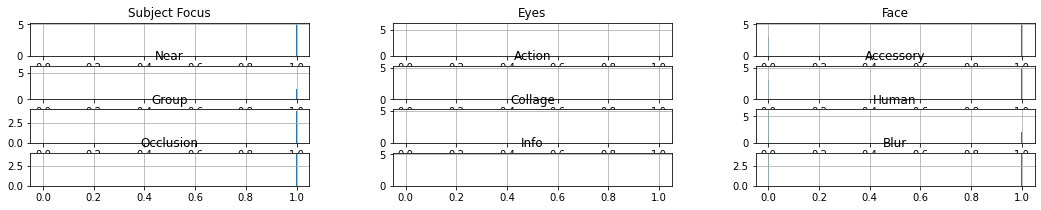

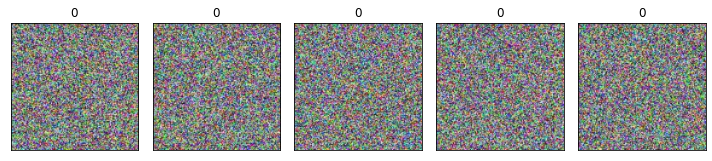

CPU times: user 13.9 s, sys: 399 ms, total: 14.3 s
Wall time: 15.4 s


In [15]:
%%time
# Cut training data
dataset_dir = mllib.cut_training_data(
    cut_ratio=settings["dataset_cut_ratio"], 
    dataset_dir_src=settings["dataset_dir_src"], 
    dataset_dir_cut=settings["dataset_dir_cut"]
)
display(dataset_dir)

# Submission data
submission_data = mllib.load_test_data(dataset_dir)
if debug: 
    display(submission_data)
    submission_data.hist(bins=500, figsize=(18,3))

# Make submission data
map_image_score_fn = lambda image, features, score, file_id: (image, score)  
submission_dataset = mllib.make_submission_data(
    dataset=mllib.load_test_dataset(
        dataset_dir=dataset_dir,
        mapping_data=submission_data,
        batch_size=settings["dataset_batch_size"],
        shuffle=settings["dataset_shuffle"],
        seed=settings["dataset_shuffle_seed"],
        image_size=settings["dataset_image_size"],
    ), 
    shrink_ratio=settings["dataset_shrink_ratio"],
    prefetch=settings["dataset_prefetch"],
)

# Submission data infos
print("Submission dataset items: %s" % (settings["dataset_batch_size"] * submission_dataset().cardinality().numpy()))
if debug:
    print("")
    print("Submission dataset:")
    mllib.plot_images_scores_from_dataset(submission_dataset().take(1).map(map_image_score_fn), with_stats=False)

## Submission

In [16]:
# Prepare model parameters
def get_model_parameters(settings):
    dataset_image_size = settings["dataset_image_size"]
    model_parameters = {
        "model_prefix": "model" + mllib.cut_suffix(settings["dataset_cut_ratio"]),
        "model_base": "xception",
        "input_shape": [dataset_image_size[0], dataset_image_size[1], 3],
        "input_shape_features": len(mllib.feature_fields),
        "output_size": 1,
        "dropout_rate": 0.3,
        "learning_rate": 5e-4,
        "dense_layers": "100",
        "dense_layers_activation": "elu",
        "preload_weights": None,
    }
    model_name = mllib.get_model_name(model_parameters)
    model_parameters["model_name"] = model_name
    return model_parameters
    
model_parameters = get_model_parameters(settings)
display(model_parameters)

{'model_prefix': 'model',
 'model_base': 'xception',
 'input_shape': [150, 150, 3],
 'input_shape_features': 12,
 'output_size': 1,
 'dropout_rate': 0.3,
 'learning_rate': 0.0005,
 'dense_layers': '100',
 'dense_layers_activation': 'elu',
 'preload_weights': None,
 'model_name': 'model-xception-input-150x150x3-dense-100-dropout-0.300'}

In [17]:
%%time
# Load model
with tf_strategy.scope():
    model = mllib.setup_model(model_parameters)
    model_file = mllib.load_model(model, settings["model_load_dir"])
    print("Loaded Weights: %s" % model_file)

Model: "model-xception-input-150x150x3-dense-100-dropout-0.300"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 150, 150, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
tf.math.subtract (TFOpLambda)   (None, 150, 150, 3)  0           tf.math.truediv[0][0]            
__________________________________________________________________________________________________
xception (Functional)           (None, 5, 5, 2048)   20861480    tf.math.subtract[0][0]           
_____________________________________________

In [18]:
%%time
# Submit not sample
with tf_strategy.scope():
    if not settings["submit_data_sample_flag"]:
        submission_data = mllib.make_submission_file(
            dataset=submission_dataset, 
            model=model, 
            submission_dir=settings["submission_dir"],
        )
        display(submission_data)

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,45.16
1,43a2262d7738e3d420d453815151079e,38.82
2,4e429cead1848a298432a0acad014c9d,40.55
3,80bc3ccafcc51b66303c2c263aa38486,42.00
4,8f49844c382931444e68dffbe20228f4,38.32
5,b03f7041962238a7c9d6537e22f9b017,42.74
6,c978013571258ed6d4637f6e8cc9d6a3,35.90
7,e0de453c1bffc20c22b072b34b54e50f,41.05


CPU times: user 3.33 s, sys: 262 ms, total: 3.59 s
Wall time: 2.98 s


In [19]:
%%time
# Submit sample
if settings["submit_data_sample_flag"]:
    submission_data = mllib.make_submission_sample_file(
        sample_dir=settings["dataset_dir_src"], 
        submission_dir=settings["submission_dir"]
    )
    display(submission_data)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


## Cleanup

In [20]:
%%time
if settings["cleanup_data_flag"]: 
    mllib.delete_training_data(cut_ratio=settings["dataset_cut_ratio"], dataset_dir_cut=settings["dataset_dir_cut"])

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11 µs
